In [4]:
system("unzip Baltimore_Streets.zip")
system("unzip Baltimore_FastFood.zip")
system("unzip Baltimore_Junctions.zip")
system("unzip BaltCrime_Murder.zip")



In [4]:
library(spdep)
library(classInt)
library(rgdal)
library(RColorBrewer)
library(spatstat)
library(maptools)
library(sp)

Loading required package: sp
Loading required package: Matrix
rgdal: version: 1.2-16, (SVN revision 698)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.2, released 2016/10/24
 Path to GDAL shared files: /usr/share/gdal/2.1
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-4 
Loading required package: nlme
Loading required package: rpart

spatstat 1.48-0       (nickname: ‘Model Prisoner’) 
For an introduction to spatstat, type ‘beginner’ 


Note: spatstat version 1.48-0 is out of date by more than a year; we strongly recommend upgrading to the latest version.
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


In [5]:
ff=readOGR( dsn= getwd() , layer="Baltimore_FastFood")
streets=readOGR( dsn= getwd() , layer="Baltimore_Streets")
murder=readOGR( dsn= getwd() , layer="BaltCrime_Murder")

OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/food-network/food network", layer: "Baltimore_FastFood"
with 181 features
It has 11 fields
Integer64 fields read as strings:  OBJECTID Zip OBJECTID_1 
OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/food-network/food network", layer: "Baltimore_Streets"
with 47460 features
It has 38 fields
Integer64 fields read as strings:  OBJECTID_1 OBJECTID_2 FRADDL TOADDL FRADDR TOADDR FRADDLA TOADDLA FRADDRA TOADDRA BLOCK_NUM 
OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/food-network/food network", layer: "BaltCrime_Murder"
with 1740 features
It has 15 fields
Integer64 fields read as strings:  CrimeTime Post Total_Inci 


OBJECTID,Type,Name,Address,City,State,County,Zip,X,Y,OBJECTID_1
66,Fast Food,Panda Express,6514 Reisterstown Rd,Baltimore,MD,Baltimore,21215,-8538549,4772880,66
69,Fast Food,Pizza Hut,6663 Belair Rd,Baltimore,MD,Baltimore City,21206,-8519336,4772626,69
72,Fast Food,A&W,6602 Reisterstown Rd,Baltimore,MD,Baltimore City,21215,-8538661,4772986,72
75,Fast Food,Blimpie,100 South Charles Street,Baltimore,MD,Baltimore City,21202,-8528750,4762965,75
76,Fast Food,Blimpie,600 N Wolfe St,Baltimore,MD,Baltimore City,21287,-8526059,4764366,76
77,Fast Food,Burger King,6605 Reisterstown Rd,Baltimore,MD,Baltimore City,21215,-8538652,4773000,77
78,Fast Food,Burger King,4400 Reisterstown Rd,Baltimore,MD,Baltimore City,21215,-8534640,4770333,78
79,Fast Food,Burger King,2301 Liberty Heights Ave,Baltimore,MD,Baltimore City,21215,-8533038,4767401,79
80,Fast Food,Burger King,1437 W Patapsco Ave,Baltimore,MD,Baltimore City,21230,-8531404,4757301,80
81,Fast Food,Burger King,1201 W North Ave,Baltimore,MD,Baltimore City,21217,-8531192,4766210,81


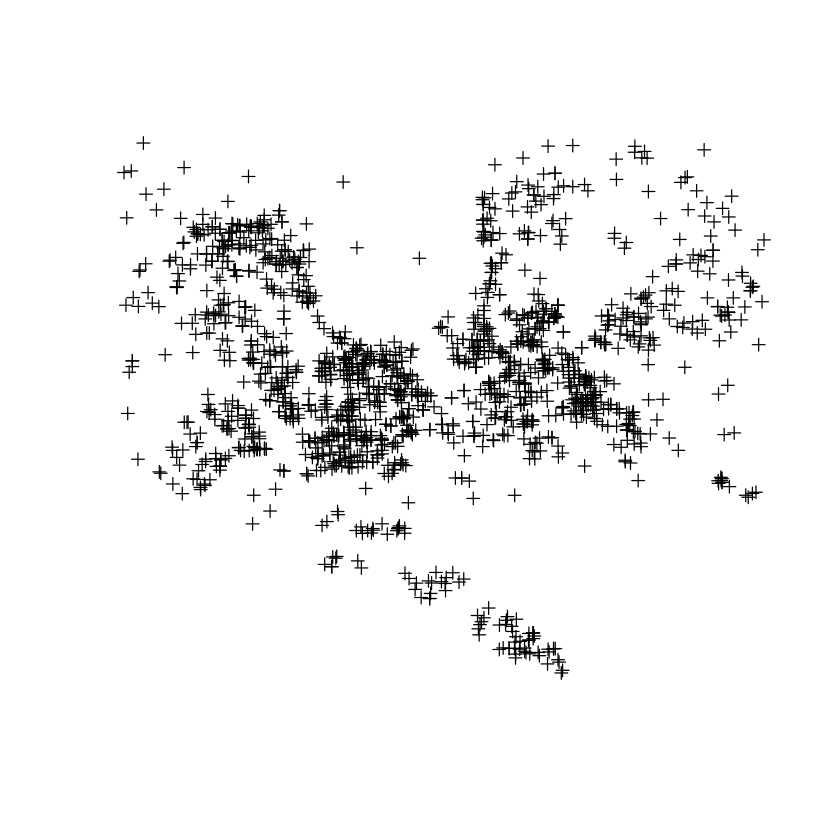

In [6]:
head(ff@data, n=10)
plot(murder)

In [7]:
#this is the Maryland projection from Arc
proj4string(ff)


[1] "+proj=lcc +lat_1=38.3 +lat_2=39.45 +lat_0=37.66666666666666 +lon_0=-77 +x_0=399999.9998983998 +y_0=0 +datum=NAD83 +units=us-ft +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [8]:
sapply(ff@data, class)
nrow(ff)
ncol(ff)

OBJECTID       Type       Name    Address       City      State     County 
  "factor"   "factor"   "factor"   "factor"   "factor"   "factor"   "factor" 
       Zip          X          Y OBJECTID_1 
  "factor"  "numeric"  "numeric"   "factor"

[1] 181

[1] 11

In [9]:
summary(ff)

Object of class SpatialPointsDataFrame
Coordinates:
                min       max
coords.x1 1394250.4 1445098.7
coords.x2  571863.8  618467.8
Is projected: TRUE 
proj4string :
[+proj=lcc +lat_1=38.3 +lat_2=39.45 +lat_0=37.66666666666666 +lon_0=-77
+x_0=399999.9998983998 +y_0=0 +datum=NAD83 +units=us-ft +no_defs
+ellps=GRS80 +towgs84=0,0,0]
Number of points: 181
Data attributes:
    OBJECTID          Type                         Name   
 100    :  1   Fast Food:181   Subway                :49  
 101    :  1                   McDonald's            :25  
 102    :  1                   Dunkin' Donuts        :21  
 103    :  1                   New York Fried Chicken:17  
 104    :  1                   Burger King           :13  
 105    :  1                   KFC                   :11  
 (Other):175                   (Other)               :45  
                     Address              City     State   
 600 N Wolfe St          :  3   Baltimore   :176   MD:181  
 1100 Light St           : 

In [10]:
summary(murder)

Object of class SpatialPointsDataFrame
Coordinates:
                min       max
coords.x1 -76.71058 -76.53076
coords.x2  39.22303  39.37192
Is projected: TRUE 
proj4string :
[+proj=lcc +lat_1=38.3 +lat_2=39.45 +lat_0=37.66666666666666 +lon_0=-77
+x_0=399999.9998983998 +y_0=0 +datum=NAD83 +units=us-ft +no_defs
+ellps=GRS80 +towgs84=0,0,0]
Number of points: 1740
Data attributes:
      CrimeDate      CrimeTime    CrimeCode                 Location   
 2015/06/02:   5   112    :   7   1F:1468   2200 N FULTON AV    :   7  
 2015/07/07:   5   230    :   7   1K: 156   1500 PENNSYLVANIA AV:   6  
 2015/11/14:   5   2302   :   7   1O: 116   5100 PARK HEIGHTS AV:   6  
 2016/05/25:   5   1315   :   6             900 BENNETT PL      :   6  
 2016/09/07:   5   1500   :   6             1200 N CAROLINE ST  :   5  
 2017/05/06:   5   1555   :   6             2700 THE ALAMEDA    :   5  
 (Other)   :1710   (Other):1701             (Other)             :1705  
    Descriptio     Inside_Out       Weapon

In [11]:
win <- owin(c(1393352.4, 1455893.1), c(558087.1, 622329.7))
FF0 <- as.ppp(coordinates(ff), win, ff$Name)

Warning message in ppp(X[, 1], X[, 2], window = win, check = check):
“data contain duplicated points”

In [12]:
summary(FF0)

Planar point pattern:  181 points
Average intensity 4.504979e-08 points per square unit

*Pattern contains duplicated points*

Coordinates are given to 2 decimal places
i.e. rounded to the nearest multiple of 0.01 units

Window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] units
Window area = 4017780000 square units

Generating 99 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,  99.

Done.


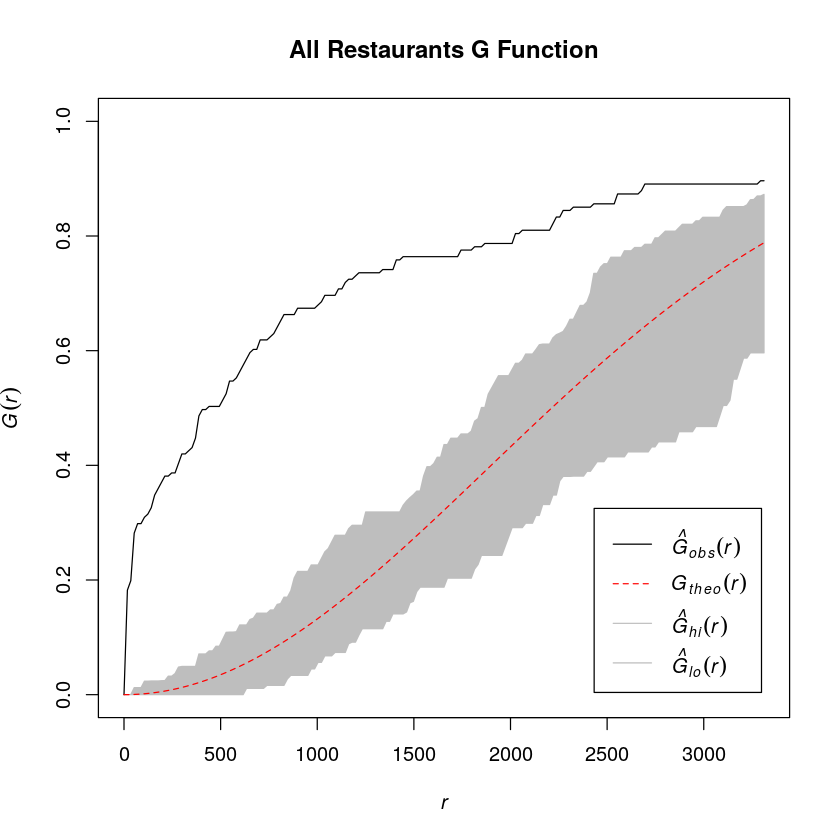

In [13]:
plot(envelope(FF0, Gest), ylim=c(0,1), main="All Restaurants G Function")

Generating 99 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,  99.

Done.


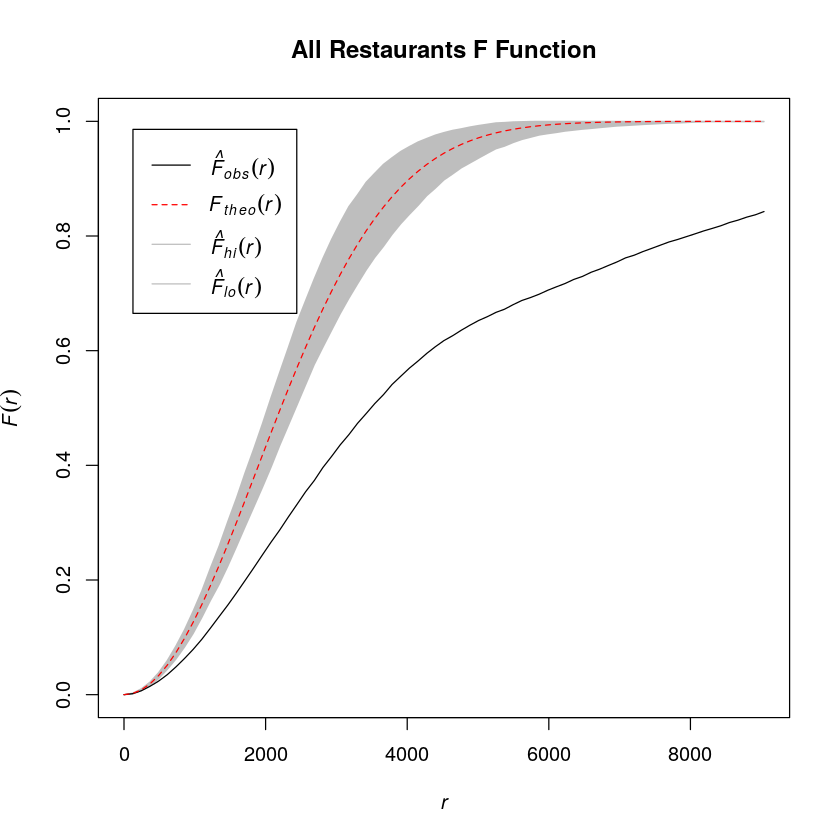

In [14]:
plot(envelope(FF0, Fest), ylim=c(0,1), main="All Restaurants F Function")


In [15]:
summary(FF0)
allFF <- split.ppp(FF0, ff$Name)
summary(allFF)

Planar point pattern:  181 points
Average intensity 4.504979e-08 points per square unit

*Pattern contains duplicated points*

Coordinates are given to 2 decimal places
i.e. rounded to the nearest multiple of 0.01 units

Window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] units
Window area = 4017780000 square units

A&W:
Planar point pattern:  1 points
Average intensity 2.488938e-10 points per square unit

Coordinates are given to 2 decimal places
i.e. rounded to the nearest multiple of 0.01 units

Window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] units
Window area = 4017780000 square units

Blimpie:
Planar point pattern:  2 points
Average intensity 4.977877e-10 points per square unit

Coordinates are given to 2 decimal places
i.e. rounded to the nearest multiple of 0.01 units

Window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] units
Window area = 4017780000 square units

Burger King:
Planar point pattern:  13 points
Average intensity 3.23562e-09 points per square unit

Coordinates are given to 2 decimal places
i.e. rounded to the nearest multiple of 0.01 units

Window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] units
Window area = 4017780000 square units

Checkers:
Planar point pattern:  2 points
Average intensity 4.977877e-10 points per square unit



In [16]:
L0 <- as.linnet.SpatialLines(streets)

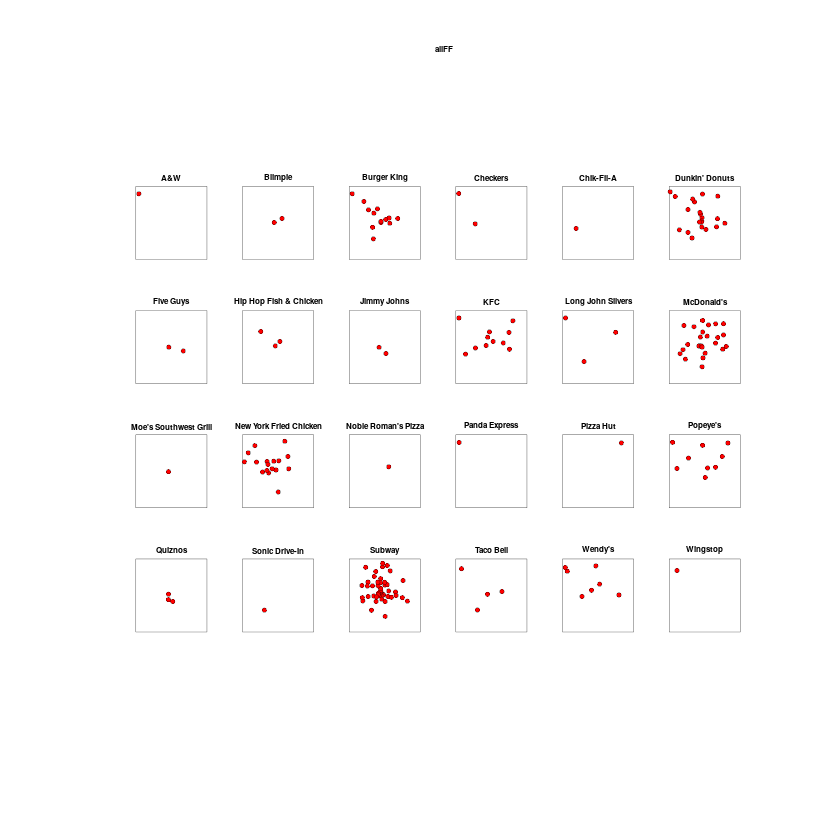

In [17]:
par(cex=1, cex.main=.4)
plot(allFF, fill=TRUE, bg="red", lwd=0.25, mar=rep(0,4), cex=.5, pch=21)

Generating 99 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,  99.

Done.


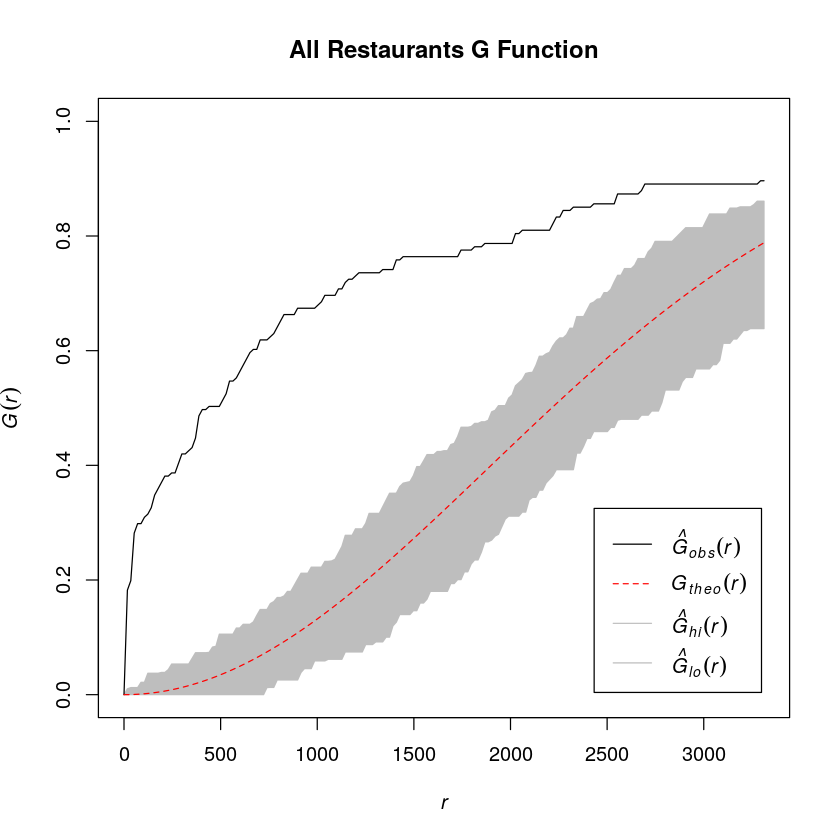

In [18]:
plot(envelope(FF0, Gest), ylim=c(0,1), main="All Restaurants G Function")

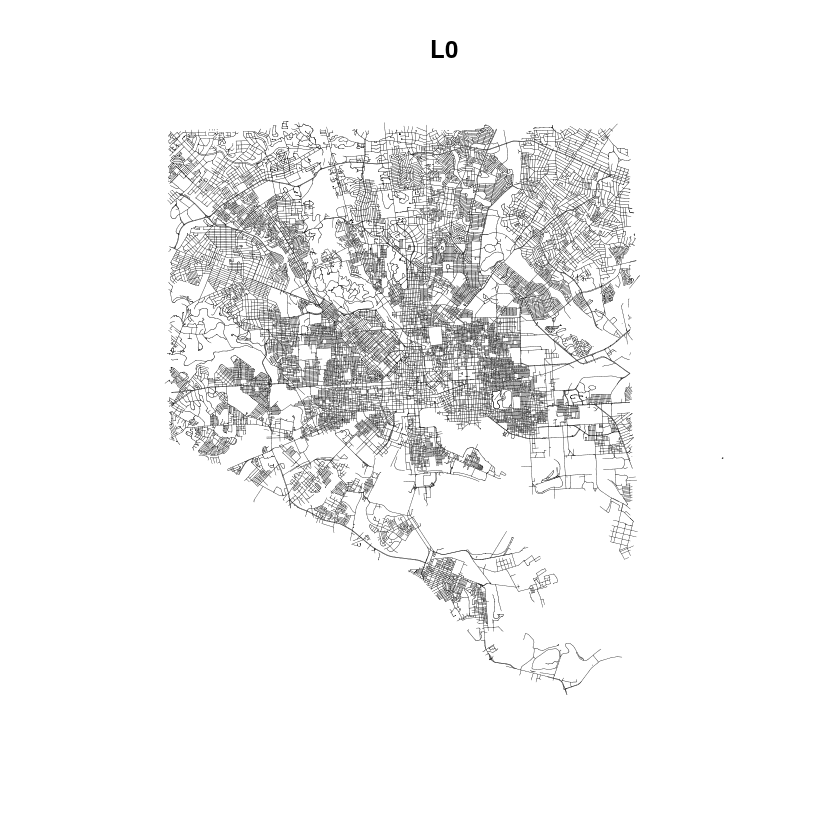

In [19]:
plot(L0, fill=TRUE, bg="skyblue", lwd=0.25, mar=rep(0,4), border=0 )

In [20]:
iX <- 1:181
iY <- 1:181
FFL <- lpp(FF0, L0)
FFLSubway <- lpp(allFF$Subway, L0)

In [21]:
summary(streets)

Object of class SpatialLinesDataFrame
Coordinates:
        min       max
x 1393352.4 1455893.1
y  558087.1  622329.7
Is projected: TRUE 
proj4string :
[+proj=lcc +lat_1=38.3 +lat_2=39.45 +lat_0=37.66666666666666 +lon_0=-77
+x_0=399999.9998983998 +y_0=0 +datum=NAD83 +units=us-ft +no_defs
+ellps=GRS80 +towgs84=0,0,0]
Data attributes:
   OBJECTID_1      OBJECTID_2    OBJECTID                  TAG       
 1      :    1   1      :    1   NA's:47460   930000000000001:    2  
 10     :    1   10     :    1                930000000000347:    2  
 100    :    1   100    :    1                930000000000350:    2  
 1000   :    1   1000   :    1                930000000000354:    2  
 10000  :    1   10000  :    1                930000000000358:    2  
 10001  :    1   10001  :    1                930000000000370:    2  
 (Other):47454   (Other):47454                (Other)        :47448  
 LAST_ORG    CAPTURE_ME           LAST_USER    
 120: 2738   BLK : 3634   EIS          : 1797  
 150:39890

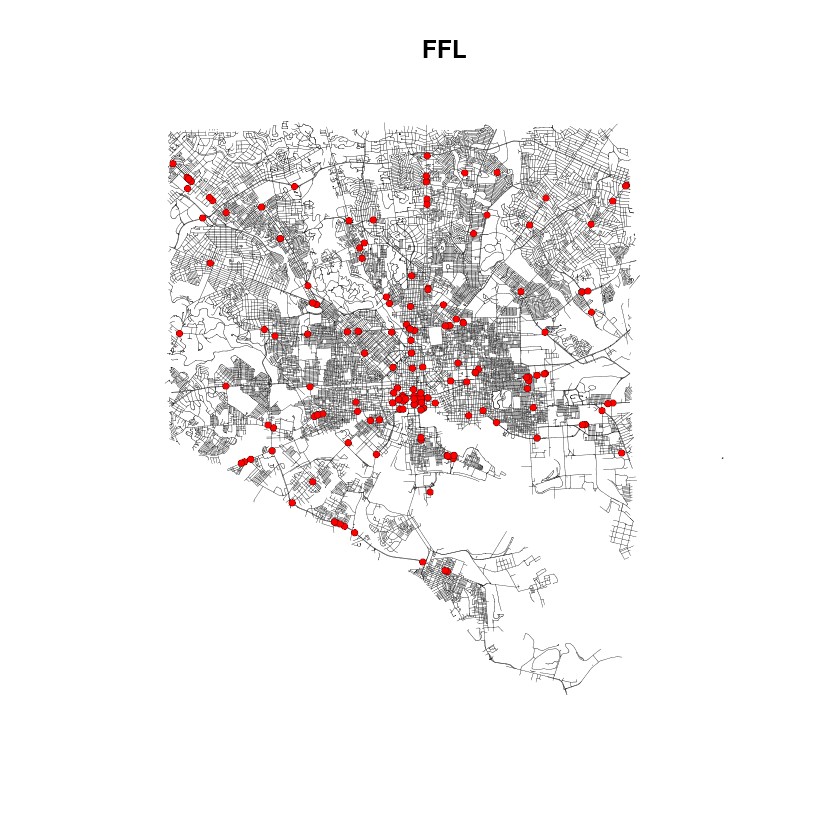

In [22]:
plot(FFL,fill=TRUE, bg="red", lwd=0.25, mar=rep(0,4), border=0, pch=21, cex=.75)

In [23]:
cross <- nndist.lpp(FFL)

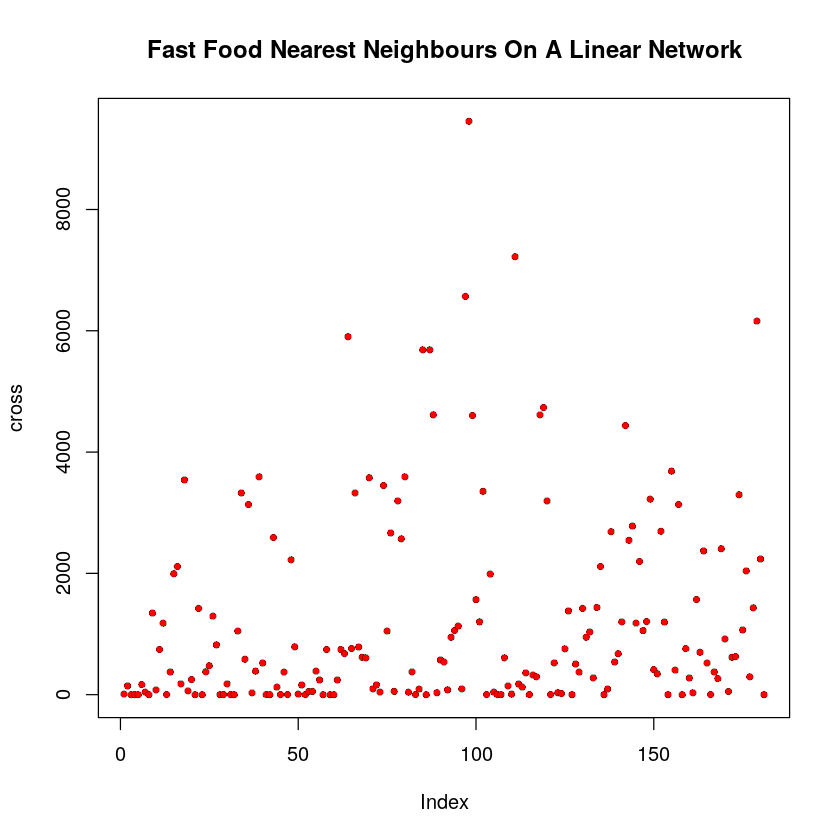

In [24]:
plot(cross,bg="red", lwd=0.25, mar=rep(0,4), pch=21, cex=.75)
title("Fast Food Nearest Neighbours On A Linear Network")

In [25]:
summary(cross)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   52.43  523.73 1200.65 1568.90 9453.58 

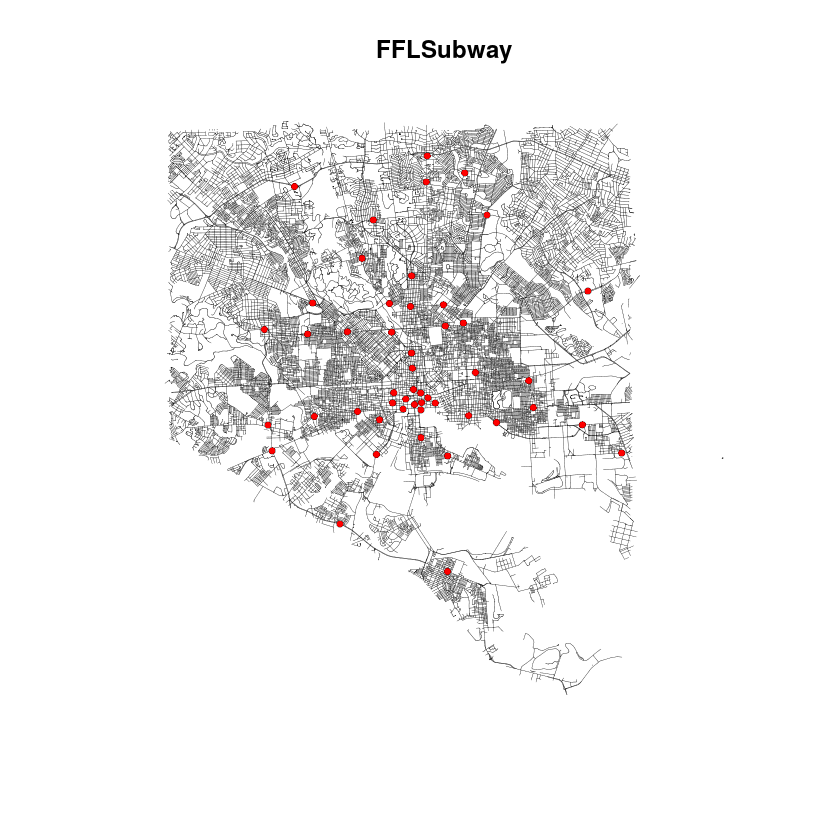

In [26]:
plot(FFLSubway,fill=TRUE, bg="red", lwd=0.25, mar=rep(0,4), border=0, pch=21, cex=.75)

In [27]:
summary(FFLSubway)

Point pattern on linear network
49 points
Linear network with 144189 vertices and 160259 lines
Total length 11440160 units
Average intensity 4.283158e-06 points per unit length
Enclosing window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] 
units

In [31]:
summary(FFLSubway)

Point pattern on linear network
49 points
Linear network with 144189 vertices and 160259 lines
Total length 11440160 units
Average intensity 4.283158e-06 points per unit length
Enclosing window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] 
units